<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
taxi_jan_2019 = pd.read_parquet('data/yellow_tripdata_2019-01.parquet')
taxi_data = pd.concat([taxi_jan_2019])

In [3]:
print(taxi_data.shape)
taxi_data.head()

(7696617, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [4]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [5]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount']]

In [6]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


Plot data into a histogram, data by column

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

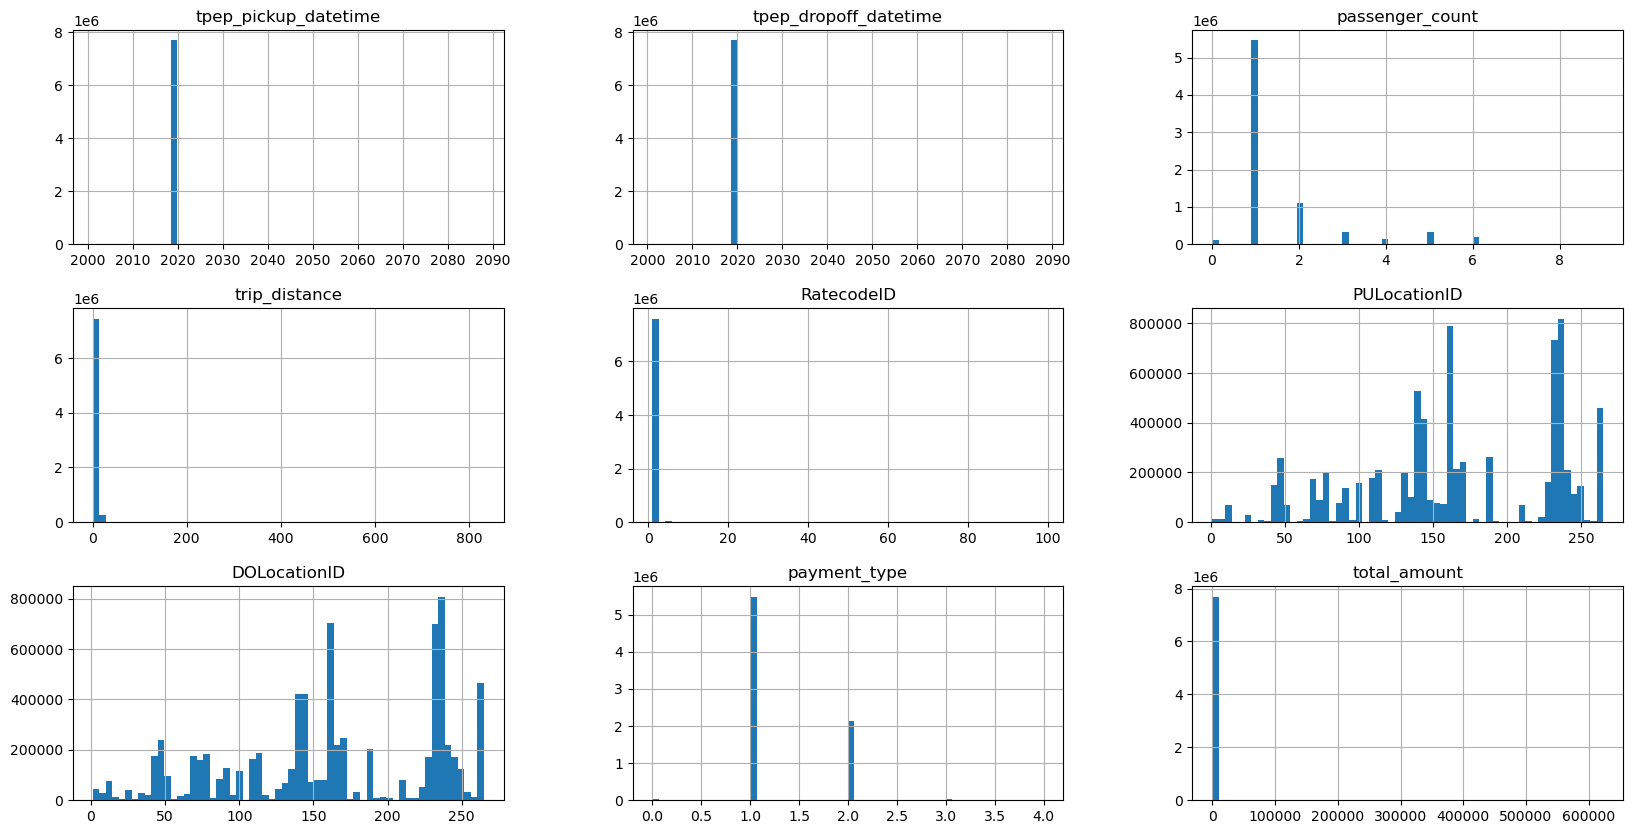

In [7]:
taxi_data.hist(figsize=(20,10), bins=60)

There are some outliers for RatecodeID. An outlier is a data point that differs significantly from other observations.

In [8]:
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     7430288
2.0      166093
5.0       54570
3.0       11801
4.0        4895
99.0        252
6.0          46
Name: count, dtype: int64

After reviewing the data, the values look okay for the Rate Code IDs in the metadata.

There are some outliers for total_amount. Plot all the data from total_amount

<Axes: xlabel='index', ylabel='total_amount'>

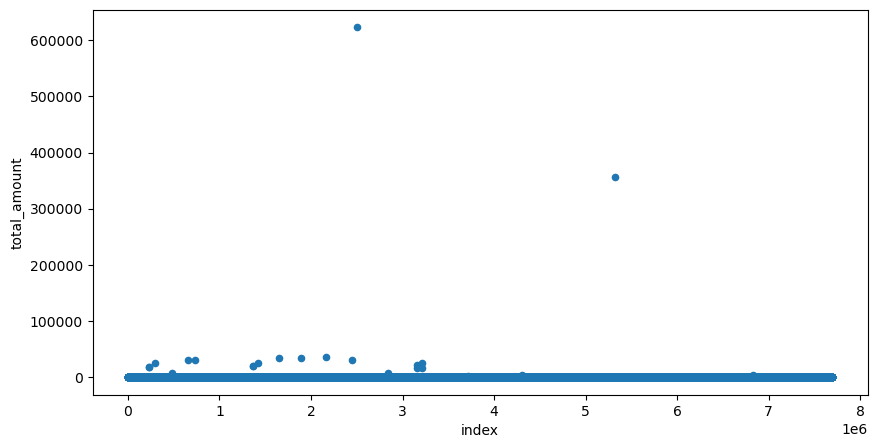

In [9]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

Filter out the outliers values above a 100000

<Axes: xlabel='index', ylabel='total_amount'>

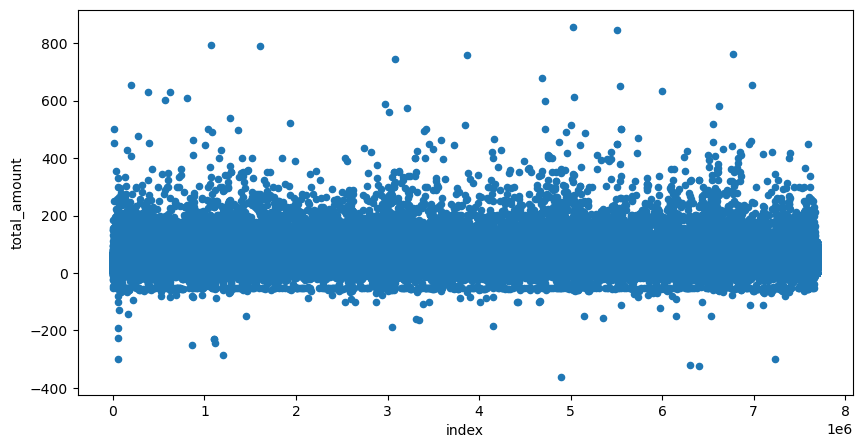

In [10]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

Two things to deal with: negative valuesand very high values. Let's first look at negative values.

Plot all negative values, values less than zero.

(7127, 9)


<Axes: xlabel='index', ylabel='total_amount'>

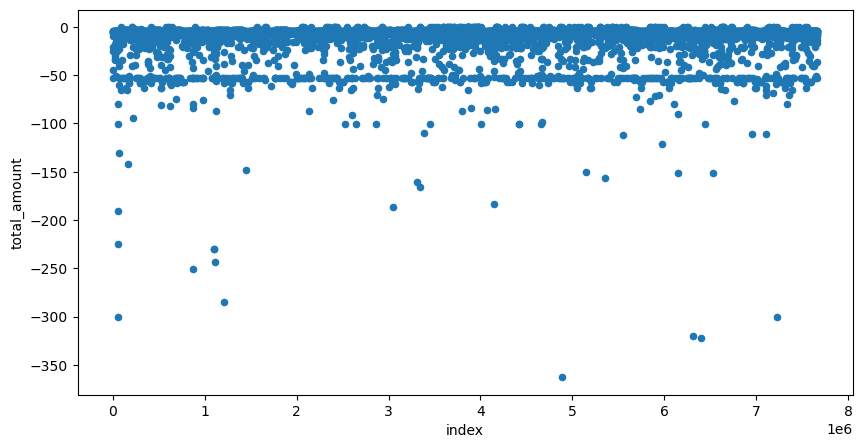

In [11]:
print(taxi_data[taxi_data['total_amount'] < 0].shape)
taxi_data[taxi_data['total_amount'] < 0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [12]:
taxi_data[taxi_data['total_amount'] < 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2.0,0.10,1.0,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1.0,4.13,1.0,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1.0,1.35,1.0,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1.0,0.00,1.0,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1.0,0.16,1.0,234,234,4,-4.3


There is a correlation between the negative values and payment_type

In [13]:
taxi_data[taxi_data['total_amount'] < 0]['payment_type'].value_counts()

payment_type
3    4083
4    2667
2     376
1       1
Name: count, dtype: int64

Payment Types: 3 = No charge, 4 = Dispute

Plot the data to get the trip distance when total_amount is less than 0

<Axes: >

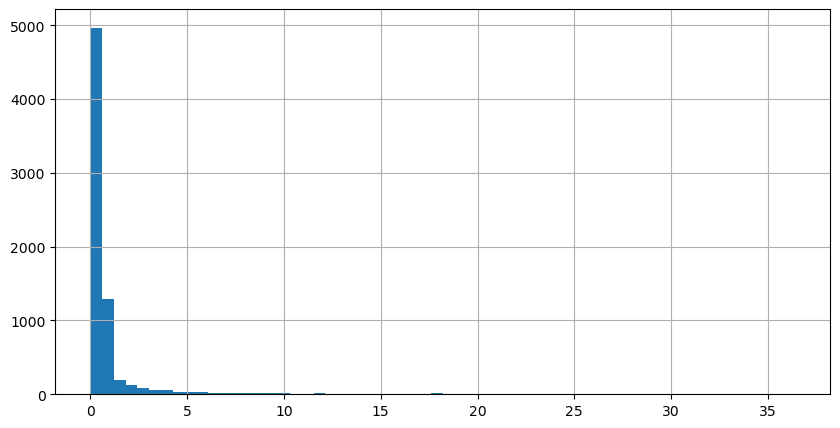

In [14]:
taxi_data[taxi_data['total_amount'] < 0]['trip_distance'].hist(bins=60, figsize=(10,5))

How many zero values are there?

In [15]:
print(taxi_data[taxi_data['total_amount'] == 0].shape)
taxi_data[taxi_data['total_amount'] == 0].head()

(1643, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.0,5.0,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1.0,0.0,5.0,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1.0,0.0,1.0,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1.0,0.0,1.0,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1.0,0.0,1.0,264,7,2,0.0


Correlation between zero values and payment_type

In [16]:
taxi_data[taxi_data['total_amount'] == 0]['payment_type'].value_counts()

payment_type
1    813
2    569
0    231
3     29
4      1
Name: count, dtype: int64

Payment Types: 1 = Credit card, 2 = Cash

Plot zero values with trip_distance

<Axes: >

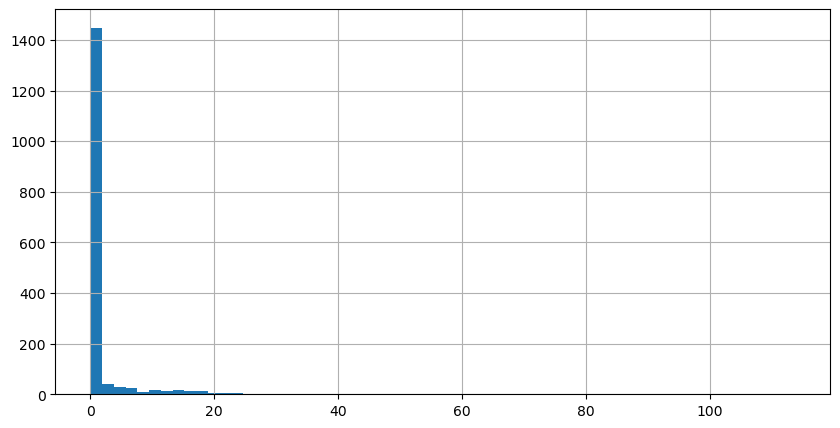

In [17]:
taxi_data[taxi_data['total_amount'] == 0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [18]:
taxi_data[taxi_data['total_amount'] == 0]['trip_distance'].value_counts()

trip_distance
0.00     1323
0.03        9
0.01        8
0.06        6
1.00        4
         ... 
11.86       1
4.59        1
20.92       1
18.37       1
12.30       1
Name: count, Length: 256, dtype: int64

We can safely get rid of the negative values. What about the very high values?

Plot to identify whre the high values are

<Axes: xlabel='index', ylabel='total_amount'>

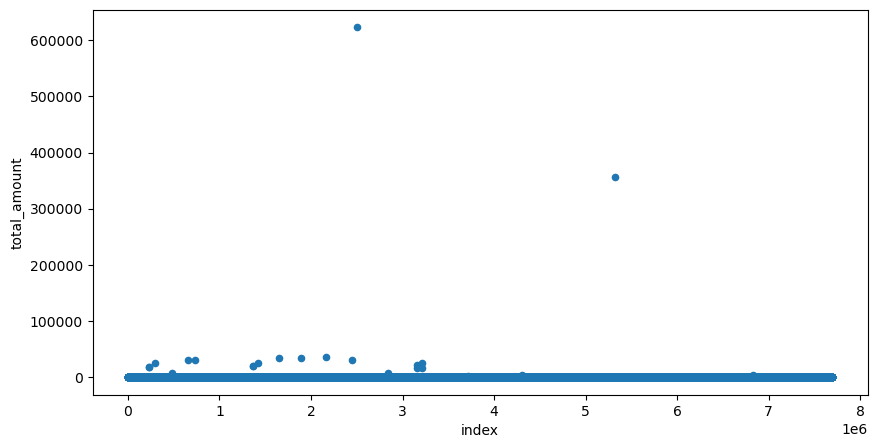

In [19]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [20]:
taxi_data[taxi_data['total_amount'] > 200].shape

(1166, 9)

What the average total payment amount is

In [21]:
taxi_data['total_amount'].mean()

15.810651344610214

We can agree to cut the data from $200 level

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

Remove all values below 0 and above 200 for Total Amount, and values below 0 for Passenger Count.

In [22]:
taxi_data_filtered =  taxi_data[(taxi_data['total_amount'] >= 0) & (taxi_data['total_amount'] < 200) & (taxi_data['passenger_count'] > 0)]

In [23]:
print(taxi_data.shape)
taxi_data_filtered.shape

(7696617, 9)


(7542337, 9)

Check for missing values.

In [24]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [25]:
# Copy data into a new data frame to not lose orginal data from the filtered data frame.
taxi_data_prepared = taxi_data_filtered.copy()

Making sure everything is in the right types

In [26]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
total_amount                    float64
dtype: object

In [27]:
# Convert to datetime
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [28]:
taxi_data_prepared['passenger_count'] = taxi_data_prepared['passenger_count'].astype(int)

In [29]:
taxi_data_prepared['RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared['PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared['DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared['payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [30]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [31]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)
# we make it datetime again because it's of very little use when it's just a string (can't compare, sort, etc)
taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day'] = taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [32]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1.0,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1.0,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1.0,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1.0,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2.0,193,193,2,55.55,2018-11-28,2018,11,28,15


There is data that do not belong to the 2019 year and the month January

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

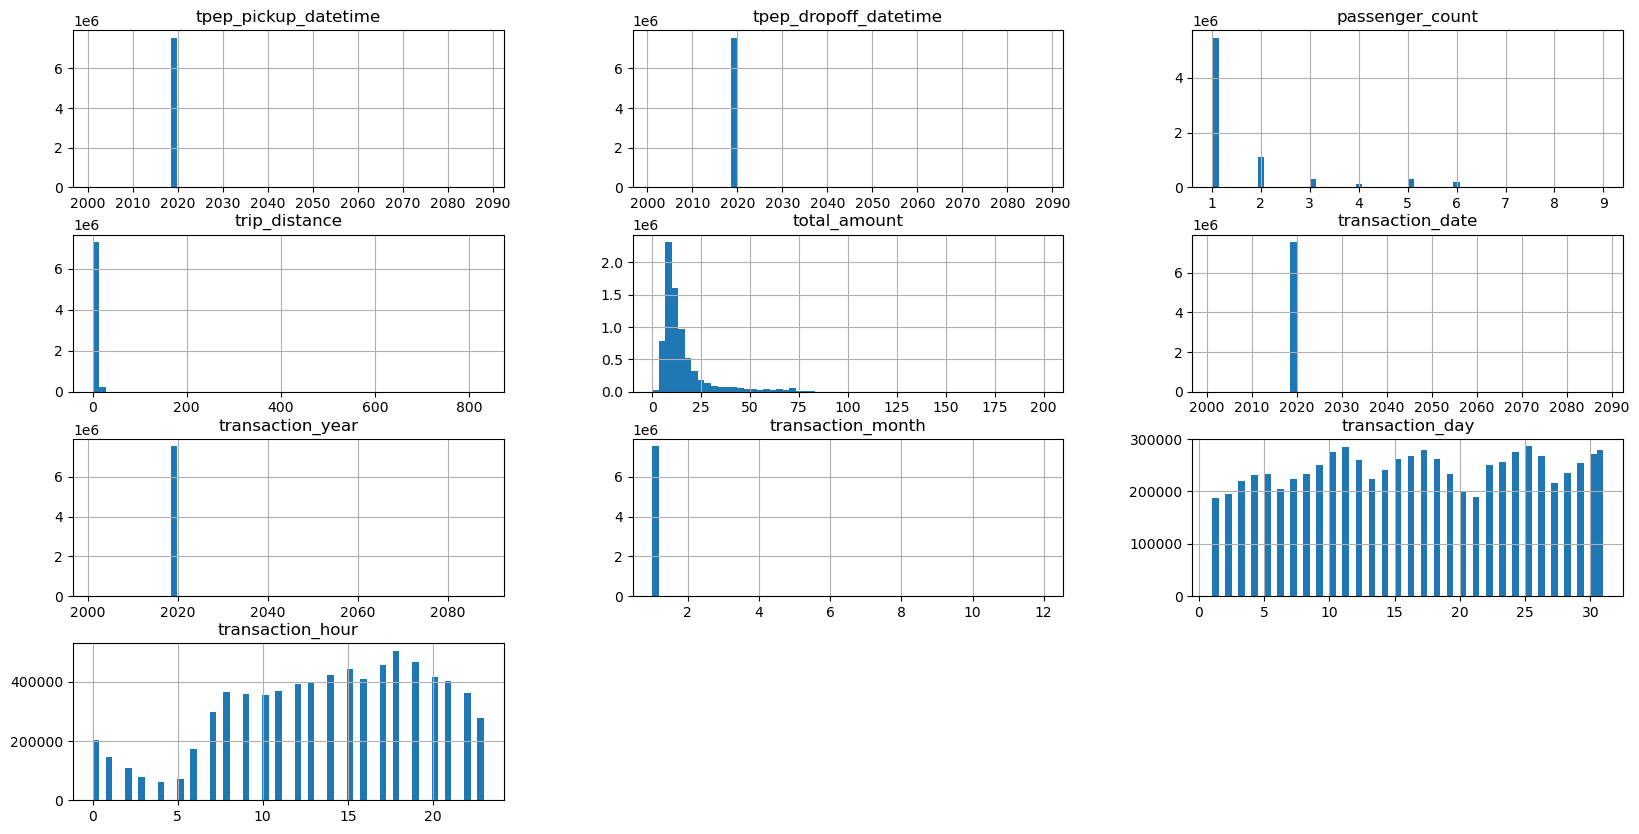

In [33]:
taxi_data_prepared.hist(figsize=(20,10), bins=60)

In the transaction_date, transaction_year, and transaction_month histograms, if you get numbers in the x axis, it means there are values, even if you do not see them.

Filter out the required data, Year=2019, Month=1.

In [34]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

Noting down categorical and numeric columns

In [35]:
categorical_columns = ['PULocationID', 'transaction_date','transaction_month','transaction_day','transaction_hour']
# total_amount is what we want to predict in the model
numerical_columns = ['trip_distance','total_amount']
all_needed_columns = categorical_columns + numerical_columns

In [36]:
main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(7541801, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


Aggregate data points.
Now is a good time to think about what we want to predict. Depending on this, we need to transform our data to have a certain format.

Group by the same categorical columns values (location, date, month, day, hour) and get the average of trip_distance and total_amount. 

Reset the index of the DF to restore the numeric index in the DF since data was filtered, resulting in a smaller DF with the numeric index that is no longer continuous.

In [37]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(102164, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


<Axes: >

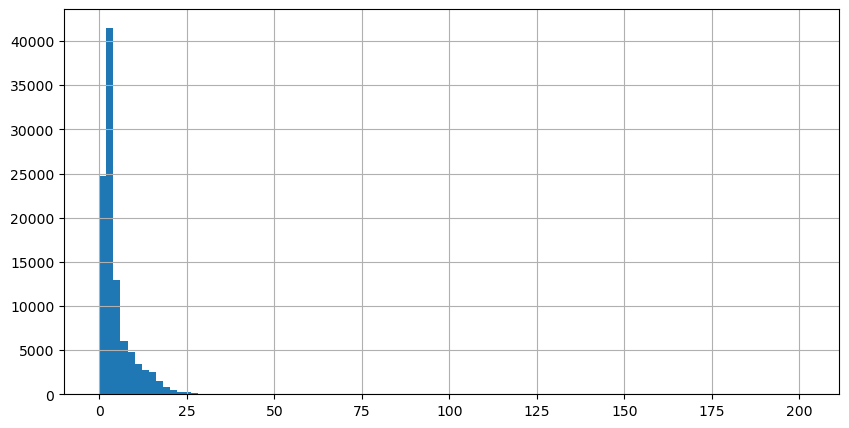

In [38]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

<Axes: >

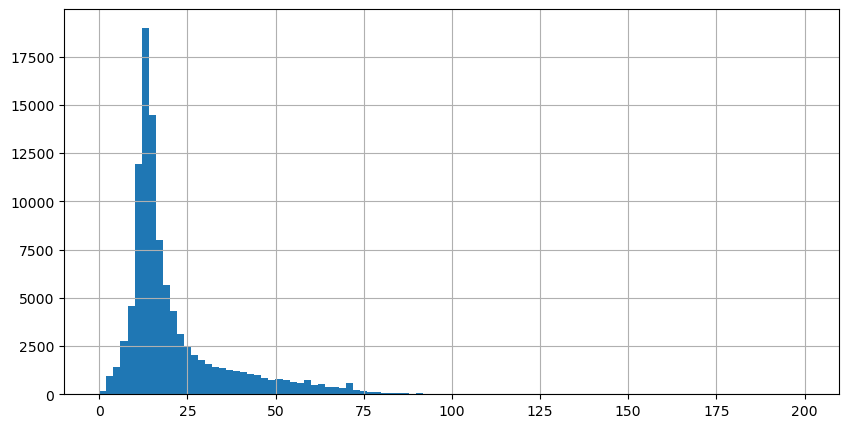

In [39]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))

# 5. Benchmark model

Benchmark model allows develpers to measure and compare the results and performance of different models. It will be passed and used during the actual training as a baseline.

In [40]:
# Create a new DF to not affect the original DF
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [41]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']

# Input features
input_features_benchmark = categorical_features_benchmark + ['trip_distance']

# Target feature (what we are trying to predict)
target_feature_benchmark = 'total_amount'

## 5.1 Train-test split

Split can vary, e.g. 80% data to train, 20% data to test

**random state**: If you don't specify the random_state in the code, then every time you run(execute) your code a new random value is generated and the train and test datasets would have different values each time.

However, if a fixed value is assigned like random_state = 0 or 1 or 42 or any other integer then no matter how many times you execute your code the result would be the same .i.e, same values in train and test datasets.

In [42]:
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode (turn categorial features values into numerical so the model can work with)
X_bench = pd.get_dummies(X_bench)

# X_train are the input features for train
# X_test are the input features for test
# y_train are the target features for train
# y_test are the target features for test

# 1/3 data to test, 2/3 data to train
# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

## 5.2 Fit a model to the data

In [43]:
# Train the model

from sklearn.tree import DecisionTreeRegressor

# max_depth: Depth of the decision tree used for training
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

## 5.3 Model Evaluation

In [46]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

## Difference between what we predicted and what the actual value was 
print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
## Difference between what we predicted and what the actual value was to show a higher value for error
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
# How good the model is doing to fit the data, 1 is perfect fit.
print('r2', r2_score(y_test_b, y_pred_b))


mean_absolute_error 3.3864686473126646
mean_squared_error 63.200949607850674
root_mean_squared_error 7.949902490461796
r2 0.7719702781577215


<Axes: xlabel='true', ylabel='pred'>

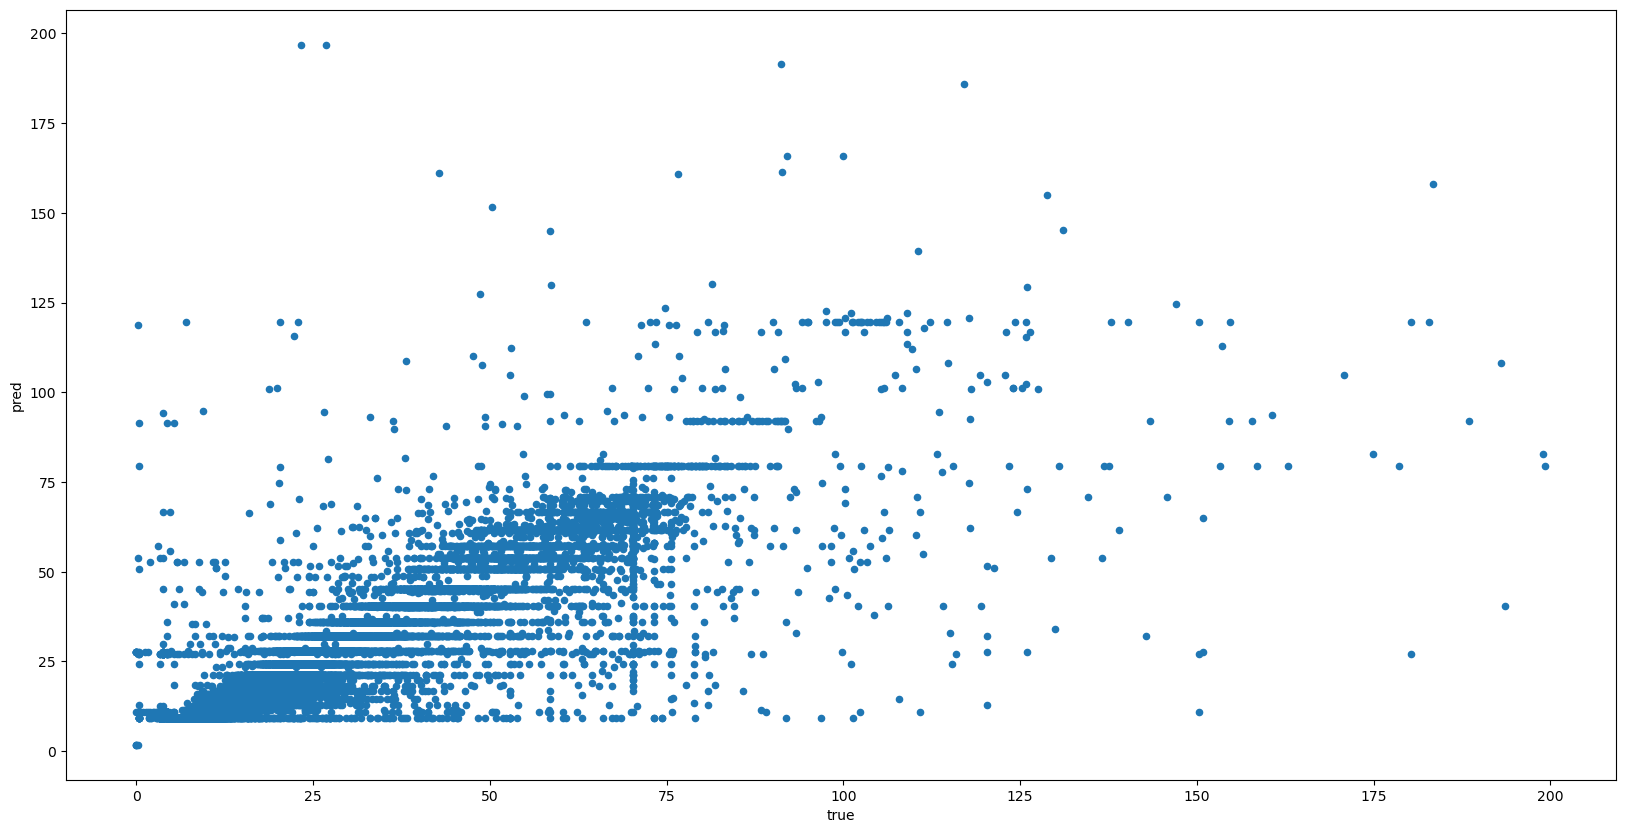

In [47]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

Could this be too good to be true?

## 5.4 Fix problems

Do not use trip_distance in the model input features.

In [48]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
# Input features
input_features_benchmark = categorical_features_benchmark
# Target feature (what we are trying to predict)
target_feature_benchmark = 'total_amount'

from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode (turn categorial features values into numerical so the model can work with)
X_bench = pd.get_dummies(X_bench)

# X_train are the input features for train
# X_test are the input features for test
# y_train are the target features for train
# y_test are the target features for test

# 1/3 data to test, 2/3 data to train
# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

# Train the model

from sklearn.tree import DecisionTreeRegressor

# max_depth: Depth of the decision tree used for training
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

## Difference between what we predicted and what the actual value was 
print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
## Difference between what we predicted and what the actual value was to show a higher value for error
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
# How good the model is doing to fit the data, 1 is perfect fit.
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 9.836578241995765
mean_squared_error 224.28544793906727
root_mean_squared_error 14.976162657338737
r2 0.19077563511065676


<Axes: xlabel='true', ylabel='pred'>

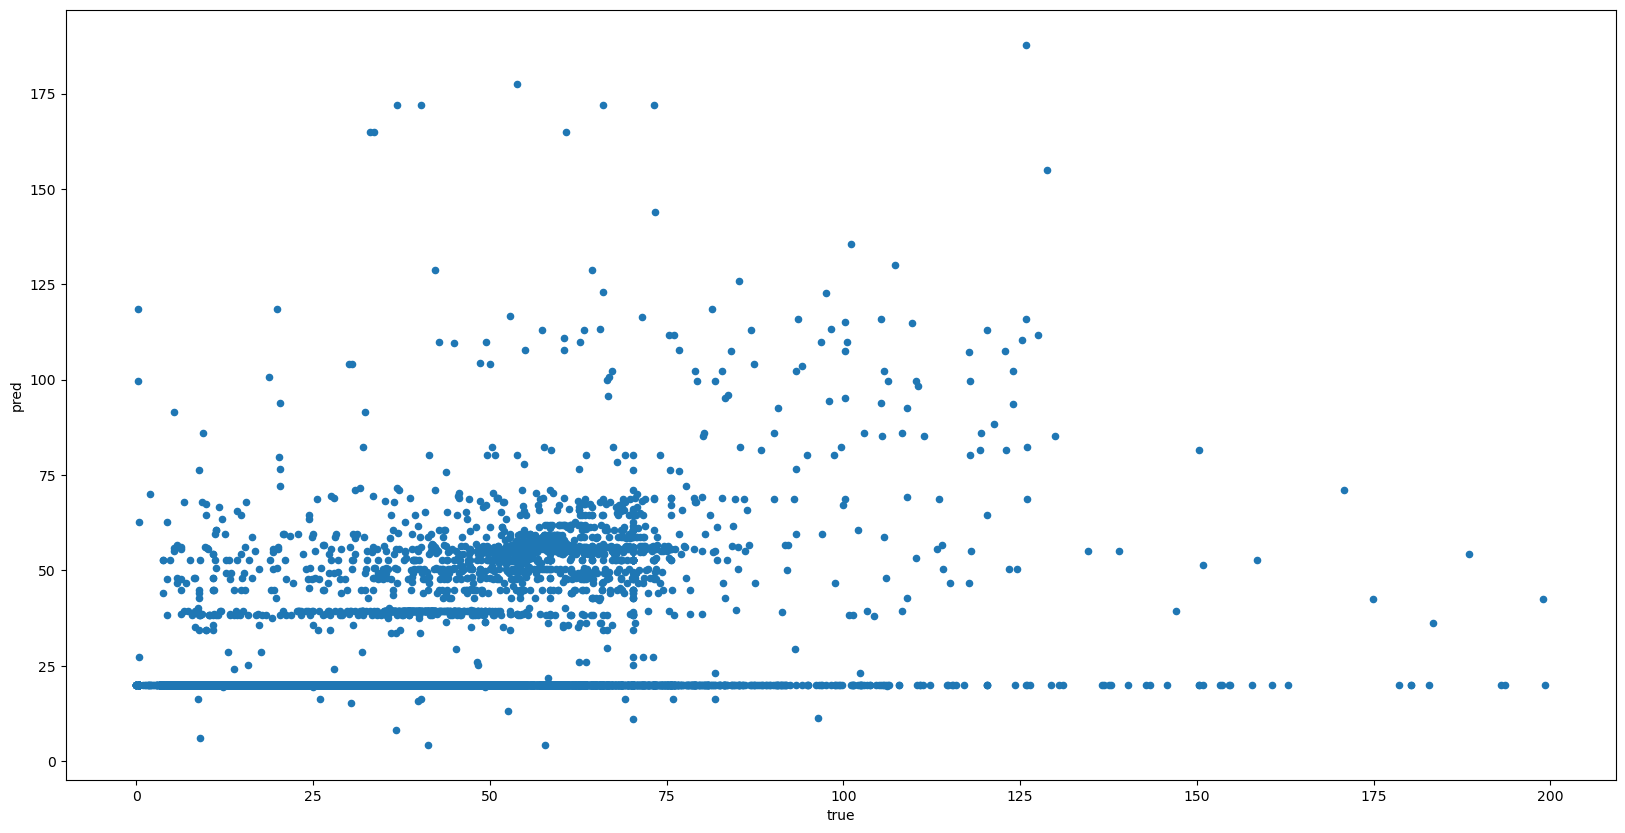

In [49]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')